In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
#importing the data
from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features.copy()
y = heart_disease.data.targets.copy()
y = (y > 0).astype(int).values.ravel()
df = X.copy()
df['target'] = y

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int32  
dtypes: float64(3), int32(1), int64(10)
memory usage: 32.1 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


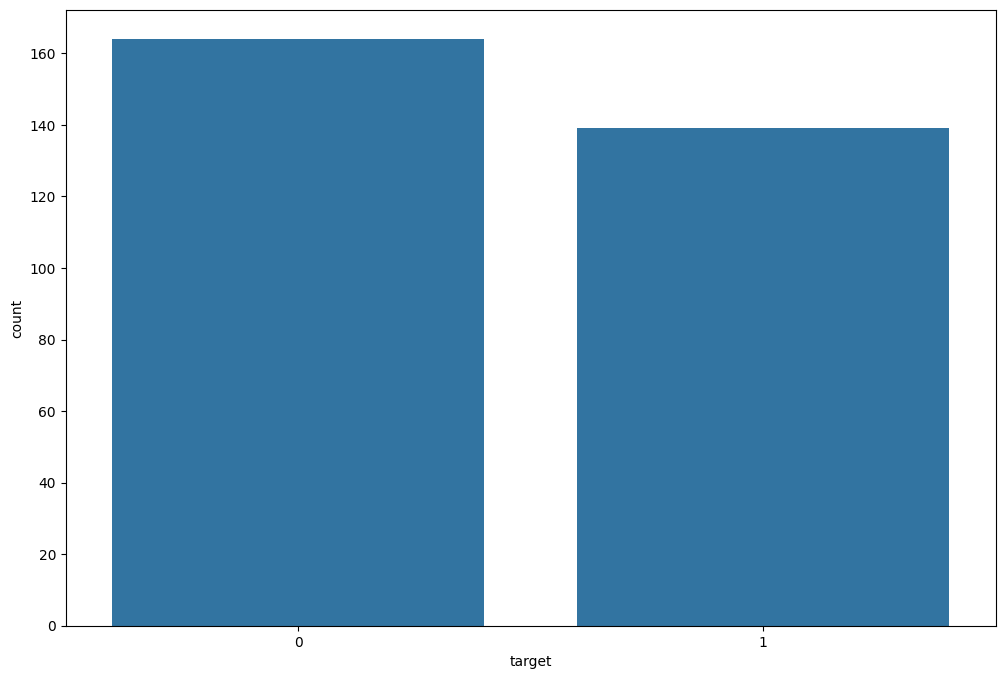

In [4]:
#plotting the target distribution
plt.figure(figsize=(12,8))
sns.countplot(x='target', data=df)
plt.savefig('target_distribution.png')
plt.show()
plt.close()


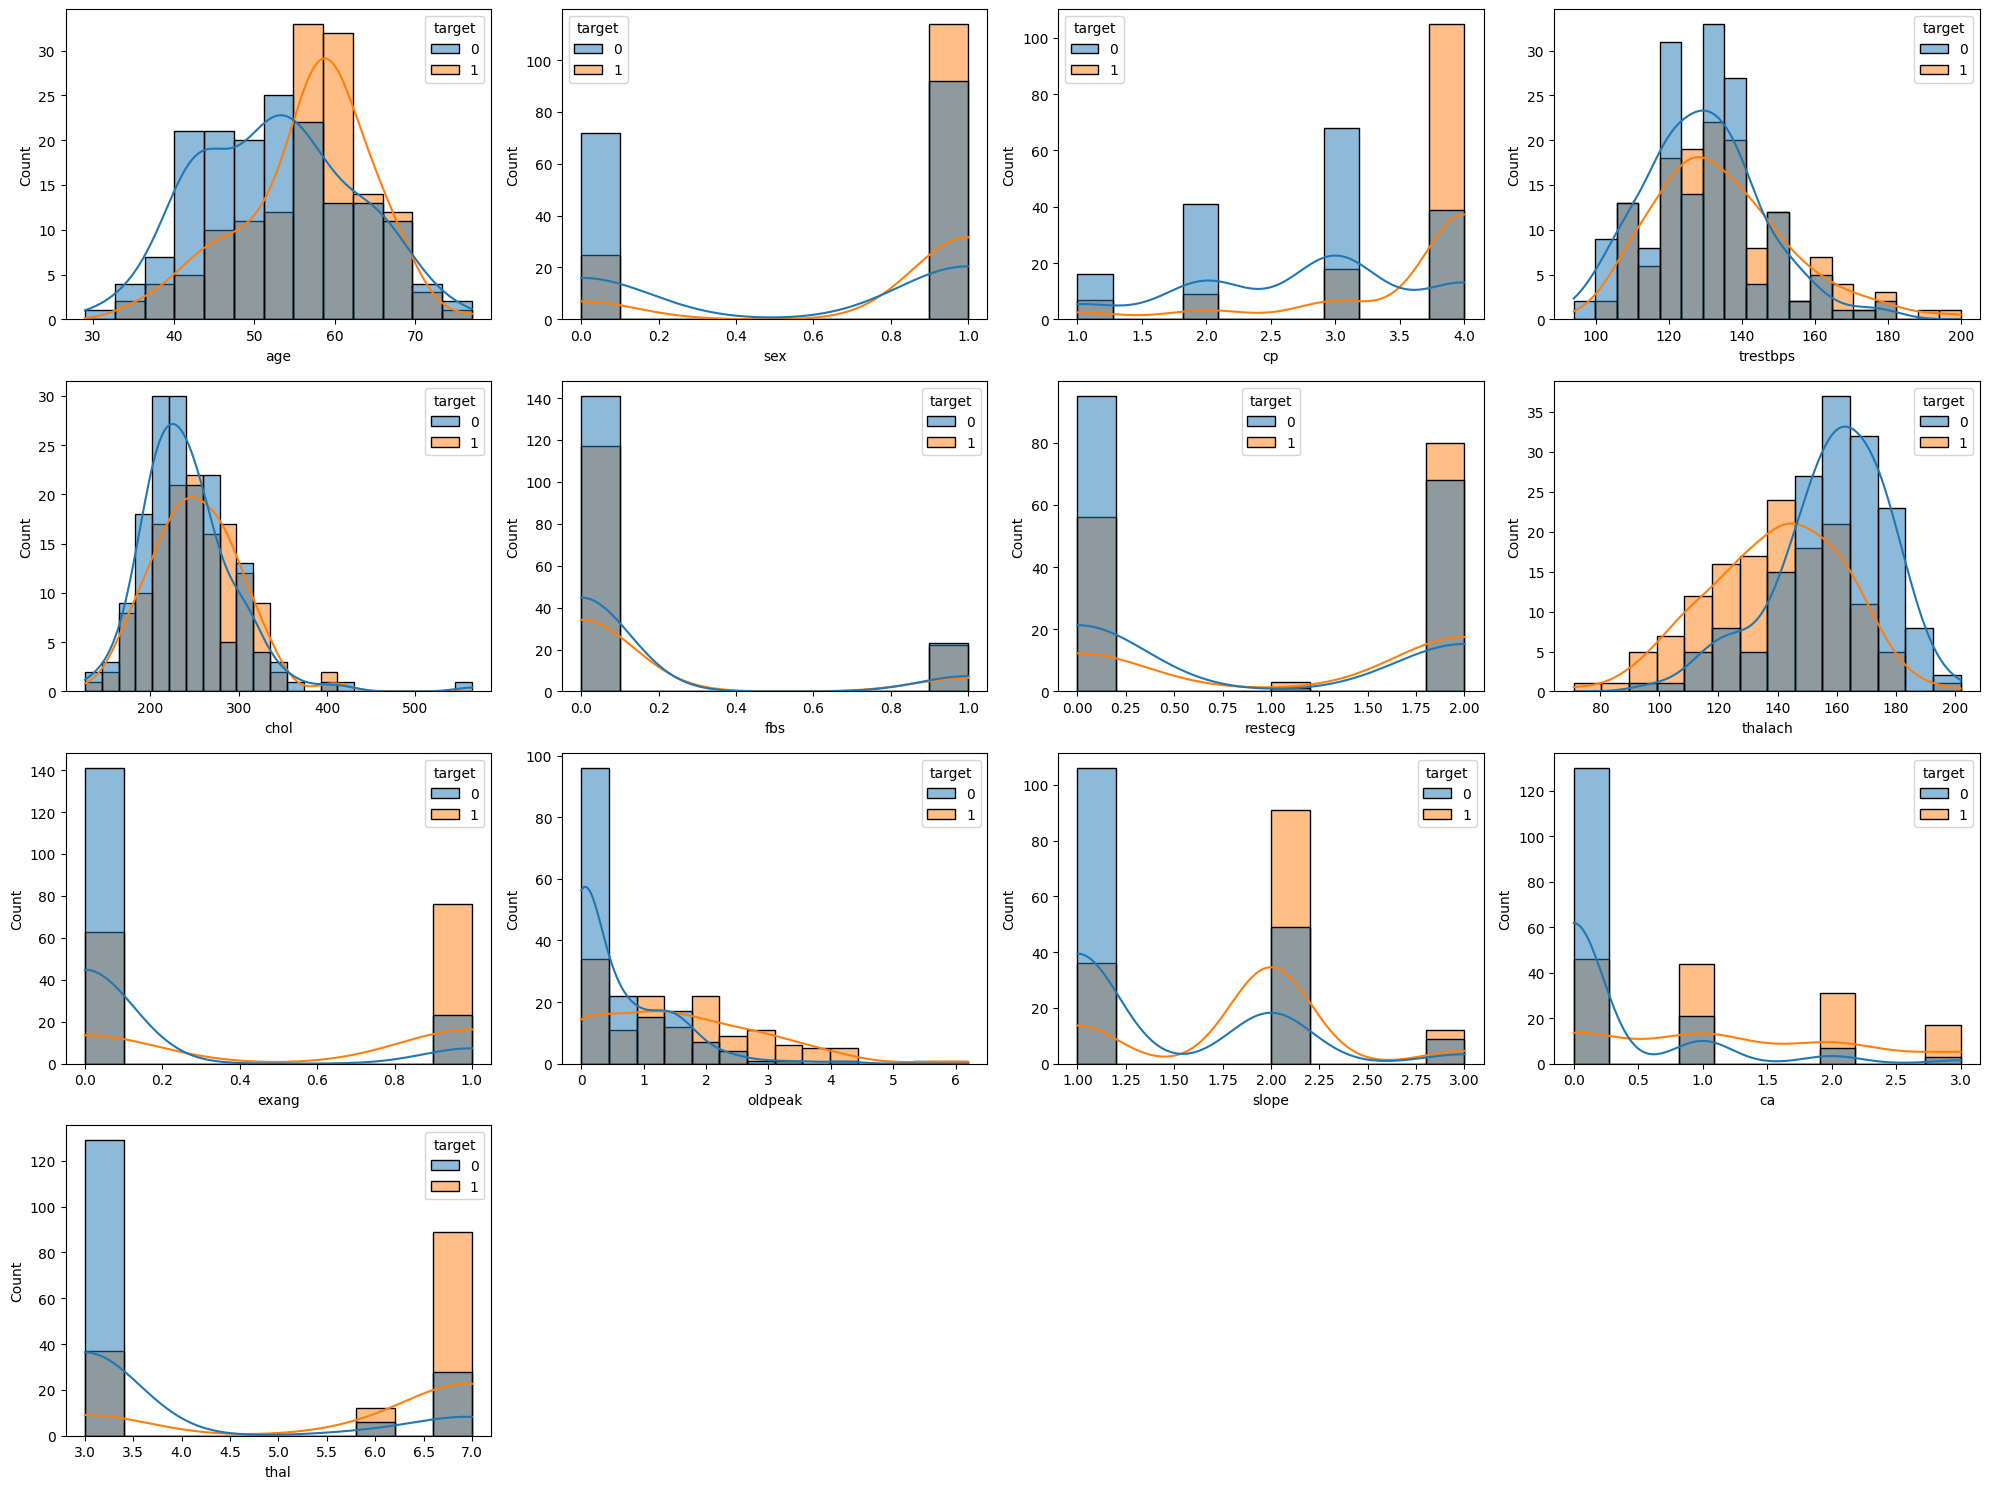

In [5]:
plt.figure(figsize=(20,15))
for i, col in enumerate(df.select_dtypes(include=['int64','float64']).columns):
    plt.subplot(4,4,i+1)
    sns.histplot(data=df, x=col, hue='target', kde=True)
plt.tight_layout()
plt.savefig('numerical_distributions.png')
plt.show()
plt.close()

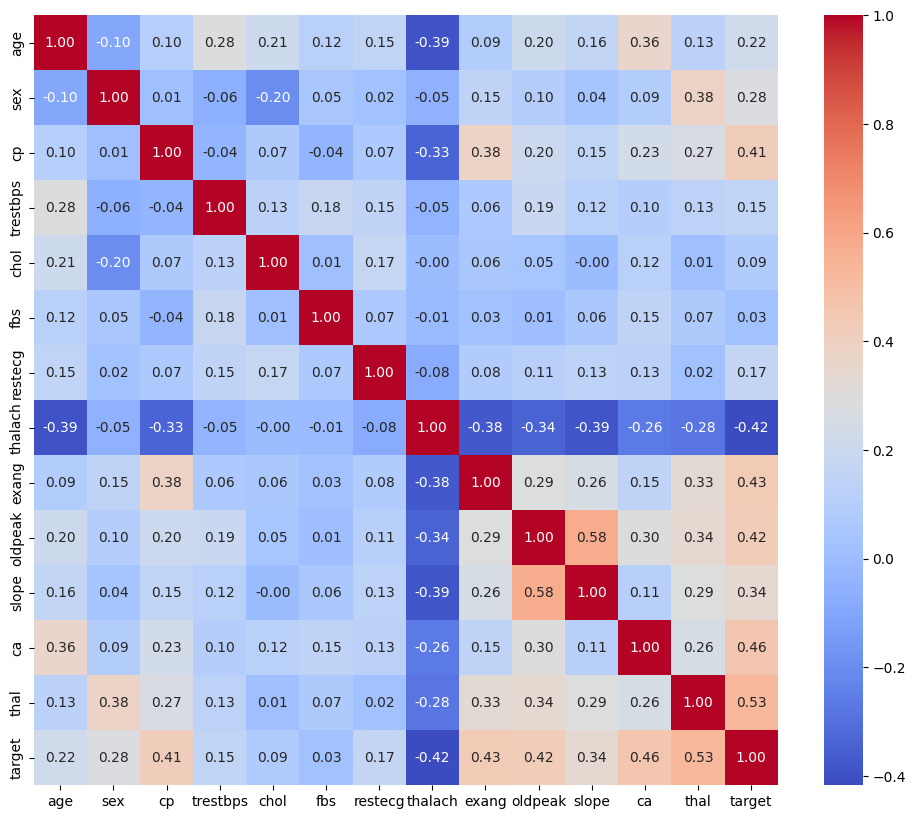

In [6]:
#plotting the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

In [7]:
#
numerical_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [8]:
#transforming the data from categorical to numeical and imputing the numerical data and scaling it.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])


In [9]:
df_cleaned = df.dropna(axis=1, how='all')  # drop columns with all NaNs
profile = ProfileReport(df_cleaned, title="Heart Disease Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<?, ?it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
#splitting the data to training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
#
scale_pos_weight = float(np.sum(y_train == 0) / np.sum(y_train == 1))

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced'),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight),
    "LGBM": LGBMClassifier(scale_pos_weight=scale_pos_weight),
    "CatBoost": CatBoostClassifier(scale_pos_weight=scale_pos_weight, silent=True),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "ExtraTrees": ExtraTreesClassifier(class_weight='balanced'),
    "NaiveBayes": GaussianNB()
}


In [12]:
#
param_grids = {
    "LogisticRegression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'saga']
    },
    "RandomForest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6, 9],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    },
    "LGBM": {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 63],
        'classifier__max_depth': [-1, 10],
        'classifier__min_child_samples': [20, 50]
    },
    "CatBoost": {
        'classifier__iterations': [100, 200],
        'classifier__depth': [4, 6],
        'classifier__learning_rate': [0.01, 0.1]
    },
    "SVM": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    "KNN": {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    "GradientBoosting": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    "AdaBoost": {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
    },
    "ExtraTrees": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
}

In [13]:
#
import warnings
warnings.filterwarnings("ignore")

results = {}
best_model = None
best_score = 0

for name in models:
    if name in param_grids:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', models[name])])
        
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=StratifiedKFold(5),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0)
        
        grid_search.fit(X_train, y_train)
        
        model = grid_search.best_estimator_
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', models[name])])
        model = pipeline.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    if results[name]['roc_auc'] > best_score:
        best_score = results[name]['roc_auc']
        best_model = model

[LightGBM] [Info] Number of positive: 111, number of negative: 131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458678 -> initscore=-0.165667
[LightGBM] [Info] Start training from score -0.165667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [14]:
import joblib
joblib.dump(best_model, 'heart_disease_model.pkl')

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='roc_auc', ascending=False).to_csv('model_results.csv')